In [1]:
import numpy as np
import sklearn as sk
from tensorflow import keras
import pandas as pd
import scipy
import tensorflow as tf

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow_docs as tfdocs
np.set_printoptions(suppress=True)
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers, layers

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline
pd.set_option('display.max_columns', 150)

In [2]:
data_un = pd.read_csv('train_data.csv', sep = ',')

In [3]:
data_un.head()

,Unnamed: 0,id_policy,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,commune_code,canton_code,city_district_code,regional_department_code,claim_amount,made_claim
0,0,A00013211-V01,0.5,Maxi,36,6,Biannual,No,Retired,68269,No,77,0,M,NaN,55,0,15,1598,111,Gasoline,RENAULT,SCENIC,16,15,185,Tourism,17517,1260,526.0,3216.0,4.8,269.0,20.0,5.0,68,0.0,0
1,1,A00040885-V01,0.5,Maxi,15,5,Yearly,No,WorkPrivate,29019,Yes,52,55,M,F,33,35,12,2184,112,Diesel,NISSAN,ALMERA TINO,12,9,180,Tourism,21500,1480,57.0,4912.0,141.3,19.0,99.0,1.0,29,0.0,0
2,2,A00044495-V01,0.5,Mini,16,6,Monthly,No,Professional,13080,No,52,0,M,NaN,34,0,20,2496,112,Diesel,LAND ROVER,DEFENDER,32,19,130,Commercial,23600,2931,257.0,4488.0,5.3,80.0,27.0,1.0,13,0.0,0
3,3,A00047266-V01,0.5,Maxi,11,7,Biannual,No,WorkPrivate,10387,No,67,0,M,NaN,46,0,12,1149,75,Gasoline,RENAULT,CLIO,14,12,170,Tourism,13050,930,109.0,1339.0,61.2,387.0,99.0,3.0,10,0.0,0
4,4,A00074532-V01,0.5,Median2,16,6,Biannual,No,WorkPrivate,59153,Yes,60,37,M,F,35,14,23,1905,93,Diesel,CITROEN,ZX,23,18,185,Tourism,17974,1035,24.0,1849.0,9.7,153.0,19.0,6.0,59,0.0,0


In [4]:
columns_x = ['pol_bonus', 'pol_coverage', 'pol_duration',
                   'pol_sit_duration', 'pol_pay_freq', 'pol_payd', 'pol_usage', 
                   'drv_drv2', 'drv_age1', 'drv_age2', 'drv_sex1',
                   'drv_sex2', 'drv_age_lic1', 'drv_age_lic2', 'vh_age', 'vh_cyl',
                   'vh_din', 'vh_fuel', 'vh_make', 'vh_sale_begin',
                   'vh_sale_end', 'vh_speed', 'vh_type', 'vh_value', 'vh_weight',
                   'town_mean_altitude', 'town_surface_area', 'population', 'city_district_code',
                  ]

x_data_un = data_un[columns_x]
y_data = data_un[['claim_amount', 'made_claim']]

cat_to_int_dict = {'pol_coverage': {'Mini':0, 'Median1':1, 'Median2':2, 'Maxi':3},
                           'pol_pay_freq': {'Monthly':0, 'Quarterly':1, 'Biannual':2, 'Yearly':3},
                           'pol_payd': {'No':0, 'Yes':1},
                           'pol_usage': {'Retired':0, 'WorkPrivate':1, 'Professional':2, 'AllTrips':3},
                           'drv_drv2': {'No':0, 'Yes':1},
                           'drv_sex1': {'F':0, 'M':1},
                           'drv_sex2': {'F':-1, 'M':1, None:0},
                           'vh_type': {'Tourism':0, 'Commercial':1,}
                           }



def car_make_categories(car_make):
    if car_make in ['RENAULT','PEUGEOT','CITROEN','VOLKSWAGEN','FORD', 'MERCEDES BENZ']:
        return car_make
    else:
        return 'OTHER'
    
def missing_geo_data(x):
    if x:
        return 1
    else:
        return 0
    
def zero_vh_weight(weight, avg_weight):
    if weight<100:
        return avg_weight
    else:
        return weight

    
x_data_f = x_data_un.replace(cat_to_int_dict, inplace=False)

x_data_f.vh_make = x_data_f['vh_make'].apply(lambda x: car_make_categories(x))

##MAKE INDEP
avg_vh_weight = x_data_f['vh_weight'].mean()
x_data_f.vh_weight = x_data_f['vh_weight'].apply(lambda x: zero_vh_weight(x, avg_vh_weight))


vh_make_cols = pd.get_dummies(x_data_f.vh_make)
vh_fuel_cols= pd.get_dummies(x_data_f.vh_fuel)
city_dist_cols= pd.get_dummies(x_data_f.city_district_code)
x_data_f = x_data_f.drop(['vh_fuel', 'vh_make', 'city_district_code'], axis = 1)

x_data_f['geoNA'] = (x_data_un['population'].isnull()).apply(lambda x: missing_geo_data(x))


x_data_f = pd.concat([x_data_f, vh_make_cols, vh_fuel_cols, city_dist_cols], axis=1, sort=False)

MEANS = x_data_f.mean()
x_data_f = x_data_f.fillna(MEANS)

In [5]:
scaler = preprocessing.MinMaxScaler()
x_data = pd.DataFrame(scaler.fit_transform(x_data_f), columns=x_data_f.columns, index=x_data_f.index)

In [6]:
x_train, x_test, y_train_b, y_test_b = train_test_split(x_data, y_data, test_size=0.2, random_state = 1)

In [7]:
y_train = y_train_b.made_claim
y_test = y_test_b.made_claim

In [9]:
average_claim_amount = y_train_b.claim_amount.mean()

In [88]:
def evaluate_model(model, sigmoid, x_test, y_test, average = 0):

    if sigmoid == True:
        predictions = model.predict_proba(x_test)
        predictions = (predictions * average).reshape(x_test.shape[0])
    else:
        predictions = (model.predict(x_test)).reshape(x_test.shape[0])
    
    return (np.abs(predictions - y_test)).sum()


In [89]:
def train_model(model, X_train, y_train, epochs = 10000):

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, 
                        epochs=epochs, validation_split = 0.2, verbose=1, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    return model, history


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

def plot_stats(hist, stat):
    #plt.plot(hist.history[stat])
    plt.plot(hist.history['val_'+stat])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [94]:
def run_whole_model_assesment(model, sigmoid, x_train = x_train, x_test = x_test, y_train_b = y_train_b, y_test_b = y_test_b):
    
    if sigmoid == True:
        y_train = y_train_b.made_claim
        y_test = y_test_b.claim_amount
    else:
        y_train = y_train_b.claim_amount
        y_test = y_test_b.claim_amount

    model, history = train_model(model, x_train, y_train)
    print('TRAINING ENDED')

    plot_stats(history, 'mse')

    print('Strategy net profitability')
    
    if sigmoid == True:
        a = y_train_b.claim_amount
        average = (a[a!=0]).mean()
        print(evaluate_model(model, sigmoid, x_test, y_test, average))
    else:
        average = 1
        print(evaluate_model(model, sigmoid, x_test, y_test))

    print((model.predict(x_test)[:10])* average)


In [22]:
evaluate_model(model, x_test, y_test_b.claim_amount, average_claim_amount)

1863751.9707753719

In [98]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def build_sigm():
  model = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=[x_train.shape[1]])
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_lin():
  model = keras.Sequential([
    layers.Dense(1, input_shape=[x_train.shape[1]])
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_sigm15_relu10_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm15_relu10_sigm10_sigm():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1, activation = 'sigmoid')
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

Train on 41600 samples, validate on 10400 samples
Epoch 1/10000
40800/41600 [============================>.] - ETA: 0s - loss: 0.0967 - mae: 0.2147 - mse: 0.0967
Epoch: 0, loss:0.0967,  mae:0.2140,  mse:0.0967,  val_loss:0.0845,  val_mae:0.1654,  val_mse:0.0845,  
41600/41600 [==============================] - 3s 63us/sample - loss: 0.0967 - mae: 0.2140 - mse: 0.0967 - val_loss: 0.0845 - val_mae: 0.1654 - val_mse: 0.0845
Epoch 2/10000
41600/41600 [==============================] - 2s 53us/sample - loss: 0.0825 - mae: 0.1612 - mse: 0.0825 - val_loss: 0.0838 - val_mae: 0.1678 - val_mse: 0.0838
Epoch 3/10000
41600/41600 [==============================] - 2s 51us/sample - loss: 0.0818 - mae: 0.1629 - mse: 0.0818 - val_loss: 0.0832 - val_mae: 0.1649 - val_mse: 0.0832
Epoch 4/10000
41600/41600 [==============================] - 2s 51us/sample - loss: 0.0814 - mae: 0.1628 - mse: 0.0814 - val_loss: 0.0828 - val_mae: 0.1671 - val_mse: 0.0828
Epoch 5/10000
41600/41600 [==========================

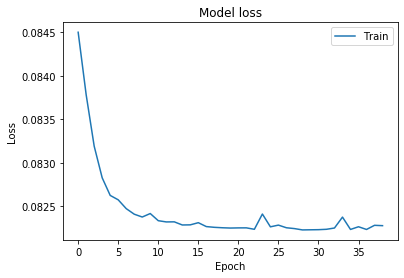

Strategy net profitability
2814905.098219089
[[ 74.28076 ]
 [168.01227 ]
 [168.18828 ]
 [157.69356 ]
 [127.47155 ]
 [ 98.502785]
 [153.36209 ]
 [110.30254 ]
 [119.16604 ]
 [120.48825 ]]


In [93]:
run_whole_model_assesment(build_sigm(), sigmoid = True)

Train on 41600 samples, validate on 10400 samples
Epoch 1/10000
41376/41600 [============================>.] - ETA: 0s - loss: 0.0830 - mae: 0.1727 - mse: 0.0830
Epoch: 0, loss:0.0829,  mae:0.1726,  mse:0.0829,  val_loss:0.0836,  val_mae:0.1662,  val_mse:0.0836,  
41600/41600 [==============================] - 6s 155us/sample - loss: 0.0829 - mae: 0.1726 - mse: 0.0829 - val_loss: 0.0836 - val_mae: 0.1662 - val_mse: 0.0836
Epoch 2/10000
41600/41600 [==============================] - 7s 172us/sample - loss: 0.0813 - mae: 0.1653 - mse: 0.0813 - val_loss: 0.0828 - val_mae: 0.1594 - val_mse: 0.0828
Epoch 3/10000
41600/41600 [==============================] - 9s 225us/sample - loss: 0.0808 - mae: 0.1634 - mse: 0.0808 - val_loss: 0.0824 - val_mae: 0.1630 - val_mse: 0.0824
Epoch 4/10000
41600/41600 [==============================] - 9s 223us/sample - loss: 0.0806 - mae: 0.1626 - mse: 0.0806 - val_loss: 0.0823 - val_mae: 0.1613 - val_mse: 0.0823
Epoch 5/10000
41600/41600 [======================

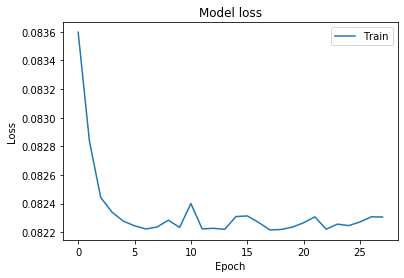

Strategy net profitability
2788561.423735275
[[ 75.94258]
 [150.5077 ]
 [164.94223]
 [156.20126]
 [130.72731]
 [109.94883]
 [136.82901]
 [111.61338]
 [106.55875]
 [123.15199]]


In [99]:
run_whole_model_assesment(build_sigm15_relu10_sigm10_sigm(), sigmoid = True)

In [ ]:
run_whole_model_assesment(build_sigm15_relu10_sigm10_lin(), sigmoid = False)

Train on 41600 samples, validate on 10400 samples
Epoch 1/10000
41504/41600 [============================>.] - ETA: 0s - loss: 501508.5218 - mae: 110.6508 - mse: 501509.1250
Epoch: 0, loss:501198.3356,  mae:110.7278,  mse:501198.9062,  val_loss:249904.7946,  val_mae:110.9214,  val_mse:249904.8125,  
41600/41600 [==============================] - 8s 194us/sample - loss: 501198.3356 - mae: 110.7278 - mse: 501198.9062 - val_loss: 249904.7946 - val_mae: 110.9214 - val_mse: 249904.8125
Epoch 2/10000
41600/41600 [==============================] - 10s 234us/sample - loss: 500057.3045 - mae: 115.5114 - mse: 500057.4375 - val_loss: 248875.5461 - val_mae: 115.3865 - val_mse: 248875.5156
Epoch 3/10000
41600/41600 [==============================] - 9s 216us/sample - loss: 499040.3705 - mae: 119.9585 - mse: 499040.4062 - val_loss: 247928.8123 - val_mae: 119.7447 - val_mse: 247928.8438
Epoch 4/10000
41600/41600 [==============================] - 10s 231us/sample - loss: 498141.0619 - mae: 124.1196 -

41600/41600 [==============================] - 11s 271us/sample - loss: 488691.0518 - mae: 172.1082 - mse: 488691.1562 - val_loss: 238673.3794 - val_mae: 170.4034 - val_mse: 238673.4062
Epoch 40/10000
41600/41600 [==============================] - 10s 250us/sample - loss: 488609.6635 - mae: 172.6231 - mse: 488609.8125 - val_loss: 238578.1158 - val_mae: 169.6841 - val_mse: 238578.0625
Epoch 41/10000
41600/41600 [==============================] - 11s 259us/sample - loss: 488523.4281 - mae: 173.1825 - mse: 488524.0000 - val_loss: 238538.8685 - val_mae: 172.4478 - val_mse: 238538.8750
Epoch 42/10000
41600/41600 [==============================] - 10s 242us/sample - loss: 488428.7691 - mae: 173.9385 - mse: 488428.7500 - val_loss: 238491.4606 - val_mae: 173.8966 - val_mse: 238491.4219
Epoch 43/10000
41600/41600 [==============================] - 10s 231us/sample - loss: 488353.8997 - mae: 174.1167 - mse: 488354.0625 - val_loss: 238467.9802 - val_mae: 175.6502 - val_mse: 238467.9375
Epoch 44/1

Epoch 80/10000
41600/41600 [==============================] - 15s 365us/sample - loss: 486620.8020 - mae: 181.3087 - mse: 486620.6875 - val_loss: 237013.3596 - val_mae: 181.1295 - val_mse: 237013.2656
Epoch 81/10000
41600/41600 [==============================] - 10s 238us/sample - loss: 486588.6643 - mae: 181.5545 - mse: 486588.5938 - val_loss: 236973.4951 - val_mae: 177.6934 - val_mse: 236973.4688
Epoch 82/10000
41600/41600 [==============================] - 9s 223us/sample - loss: 486562.1870 - mae: 181.1440 - mse: 486562.8438 - val_loss: 236954.5334 - val_mae: 180.1359 - val_mse: 236954.5625
Epoch 83/10000
41600/41600 [==============================] - 10s 244us/sample - loss: 486517.1078 - mae: 181.5439 - mse: 486516.9688 - val_loss: 236902.1061 - val_mae: 177.2350 - val_mse: 236902.0781
Epoch 84/10000
41088/41600 [============================>.] - ETA: 0s - loss: 490181.5975 - mae: 180.8025 - mse: 490181.9375

In [35]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(x_train, y_train_b.made_claim)

/home/huawei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [77]:
a = y_train_b.claim_amount
average_claim_amount = (a[a!=0]).mean()
evaluate_model(clf, True, x_test, (y_test_b.claim_amount), average_claim_amount)

2847910.7155273557

In [62]:
predictions = clf.predict_proba(x_test)

In [64]:
predictions

array([[0.93636983, 0.06363017],
       [0.86214123, 0.13785877],
       [0.84910536, 0.15089464],
       ...,
       [0.86676007, 0.13323993],
       [0.87617558, 0.12382442],
       [0.9529641 , 0.0470359 ]])

In [63]:
avg = 10
[x[1]*avg for x in predictions]

[0.6363017062209091,
 1.3785876636622567,
 1.50894638339885,
 1.3906467086435659,
 1.249353752408017,
 0.9116522147987607,
 1.2895803808300041,
 0.974652346566599,
 0.9645687657790868,
 1.162357236918943,
 1.6113400839588436,
 0.6121884095093317,
 1.2402540469990855,
 0.29786006076792404,
 0.655896362636429,
 0.9982682312650908,
 0.4884806453157536,
 1.5292455231968427,
 1.1163335778255072,
 1.5854217640275328,
 0.7144063615714801,
 0.5833815810750008,
 1.0440823808725517,
 0.9313306453793315,
 0.6063121812965209,
 0.8246393578742738,
 1.2004243090292686,
 0.3261874839855119,
 0.8503661869837171,
 0.16430347341131263,
 0.38001359517905864,
 0.9694125226438626,
 0.607458509857691,
 0.26143473239359977,
 0.7274510077443201,
 0.9730025799360127,
 0.6669120649653,
 0.21876229560323573,
 1.0566199017820597,
 1.2468306842516346,
 0.7312505086883626,
 1.0091326323272247,
 1.041585476803347,
 1.0049821136537254,
 1.192673645424216,
 0.6330129475687294,
 1.0327338015259229,
 1.3187477444769953,

In [65]:
z = y_train_b.claim_amount

In [67]:
(z[z != 0]).mean()

1171.6317863954275